In [12]:
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division


In [13]:
import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [14]:
pyoff.init_notebook_mode()

In [15]:
tx_data = pd.read_csv('data.csv')

In [16]:
tx_data.head(10)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
5  12/1/2010 8:26       7.65     17850.0  United Kingdom  
6  12/1/2010 8:26       4.25     17850.0  United Kingdom  
7  12/1/2010 8:28       1.85     17850.0  United Kingdom  
8  12/1/2010 8:28       1.85     17850.0  United Kingdom  
9  12/1/2010 8:34       1.69     13047.0  United Kingdom

In [17]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

In [18]:
tx_data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [19]:
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

In [20]:
tx_user = pd.DataFrame(tx_data['CustomerID'].unique())
tx_user.columns = ['CustomerID']

# Recency

In [21]:
tx_max_purchase = tx_uk.groupby('CustomerID').InvoiceDate.max().reset_index()

In [22]:
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [23]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [24]:
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

In [25]:
tx_user.head()

CustomerID  Recency
0     17850.0      301
1     13047.0       31
2     13748.0       95
3     15100.0      329
4     15291.0       25

In [26]:
tx_user.Recency.describe()

count    3950.000000
mean       90.778481
std       100.230349
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

In [27]:
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

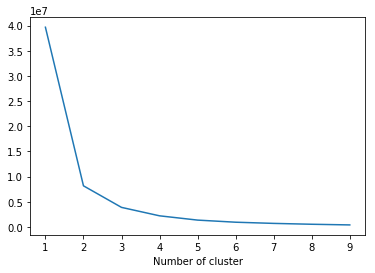

In [29]:
from sklearn.cluster import KMeans


sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [34]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [39]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

count        mean        std    min     25%    50%     75%  \
RecencyCluster                                                                
0                478.0  304.393305  41.183489  245.0  266.25  300.0  336.00   
1                568.0  184.625000  31.753602  132.0  156.75  184.0  211.25   
2                954.0   77.679245  22.850898   48.0   59.00   72.5   93.00   
3               1950.0   17.488205  13.237058    0.0    6.00   16.0   28.00   

                  max  
RecencyCluster         
0               373.0  
1               244.0  
2               131.0  
3                47.0

In [37]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [38]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

# Frequency

In [42]:
tx_frequency = tx_uk.groupby('CustomerID').InvoiceDate.count().reset_index()

In [43]:
tx_frequency.columns = ['CustomerID','Frequency']

In [44]:
tx_frequency.head()

CustomerID  Frequency
0     12346.0          2
1     12747.0        103
2     12748.0       4642
3     12749.0        231
4     12820.0         59

In [45]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

In [46]:
tx_user.head()

CustomerID  Recency  RecencyCluster  Frequency
0     17850.0      301               0        312
1     15100.0      329               0          6
2     18074.0      373               0         13
3     16250.0      260               0         24
4     13747.0      373               0          1

In [47]:
tx_user.Frequency.describe()

count    3950.000000
mean       91.614684
std       220.557389
min         1.000000
25%        17.000000
50%        41.000000
75%       101.000000
max      7983.000000
Name: Frequency, dtype: float64

In [48]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



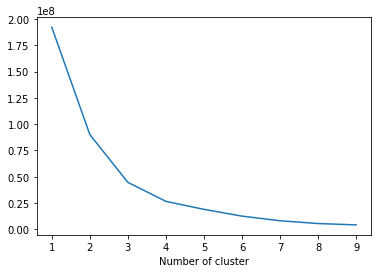

In [49]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [50]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [53]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

count         mean          std     min     25%     50%  \
FrequencyCluster                                                             
0                 3496.0    49.525744    44.954212     1.0    15.0    33.0   
1                  429.0   331.221445   133.856510   191.0   228.0   287.0   
2                   22.0  1313.136364   505.934524   872.0   988.5  1140.0   
3                    3.0  5917.666667  1805.062418  4642.0  4885.0  5128.0   

                     75%     max  
FrequencyCluster                  
0                   73.0   190.0  
1                  399.0   803.0  
2                 1452.0  2782.0  
3                 6555.5  7983.0

In [52]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

# Monetary Value

In [193]:
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']

In [194]:
tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()

In [195]:
tx_revenue.head()

CustomerID   Revenue
0     12346.0      0.00
1     12747.0   4196.01
2     12748.0  29072.10
3     12749.0   3868.20
4     12820.0    942.34

In [196]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

In [197]:
tx_user.Revenue.describe()

count      3950.000000
mean       1713.385669
std        6548.608224
min       -4287.630000
25%         282.255000
50%         627.060000
75%        1521.782500
max      256438.490000
Name: Revenue, dtype: float64

In [198]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [199]:
import warnings
warnings.filterwarnings("ignore")

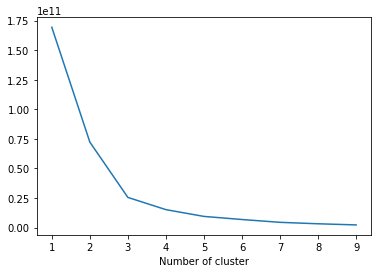

In [200]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [201]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [202]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [203]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

count           mean           std        min          25%  \
RevenueCluster                                                                
0               3688.0     908.182672    923.507907   -4287.63     263.3325   
1                233.0    7775.420687   3638.011093    4345.50    5178.9600   
2                 27.0   43070.445185  15939.249588   25748.35   28865.4900   
3                  2.0  221960.330000  48759.481478  187482.17  204721.2500   

                       50%         75%        max  
RevenueCluster                                     
0                  572.685    1258.675    4330.67  
1                 6568.720    9167.820   21535.90  
2                36351.420   53489.790   88125.38  
3               221960.330  239199.410  256438.49

# Overall Segmentation

In [204]:
tx_user.head()

CustomerID  Recency  RecencyCluster  Frequency_x    Segment  Frequency_y  \
0     17850.0      301               0          312  Low-Value          312   
1     14688.0        7               3          359  Low-Value          359   
2     13767.0        1               3          399  Low-Value          399   
3     15513.0       30               3          314  Low-Value          314   
4     14849.0       21               3          392  Low-Value          392   

   Frequency  FrequencyCluster   Revenue  RevenueCluster  
0        312                 1   5288.63               1  
1        359                 1   5107.38               1  
2        399                 1  16945.71               1  
3        314                 1  14520.08               1  
4        392                 1   7904.28               1

In [205]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [213]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

Recency    Frequency        Revenue
OverallScore                                        
0             304.584388    21.995781     303.339705
1             185.362989    32.596085     498.087546
2              78.972856    47.060803     871.842586
3              20.662252    68.374172    1089.271213
4              14.892617   271.755034    3607.097114
5               9.662162   373.290541    9136.946014
6               7.740741   876.037037   22777.914815
7               1.857143  1272.714286  103954.025714
8               1.333333  5917.666667   42177.930000

In [214]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0     474
1     562
2     921
3    1510
4     298
5     148
6      27
7       7
8       3
Name: Recency, dtype: int64

In [215]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [224]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [227]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [228]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)